## Tutorial #4: Machine Learning Algorithms for EEG Data of Single Participants

In this tutorial, we will introduce how machine learning (ML) algorithms can be applied on EEG data.

##### Dataset:
For demonstration purposes, we will use the 'Emotion-Antecedent Appraisal Checks:
EEG and EMG data sets for Novelty and Pleasantness' dataset. In this dataset there are 26 participants, each of them viewing a series of images (familiar/novel/target) with varying levels of pleantness (pleasant/unpleasant/neutral).

We thus label EEG responses to images by two letters: the first indicates level of familiarity (e.g. F for Familiar) and the second the level of pleasantness (e.g. P for pleasant). For example, the label 'FP' indicates an EEG response to a Familar-Pleasant image.

As the vast majority of presented images were familar (70% of the total images), for this tutorial we will use familiar pictures to classify whether a presented image was pleasant, unpleasant or neutral, based on EEG responses alone.

Note that only one participant will be used in this tutorial.



##### Machine Learning Algorithms:

When it comes to classification of EEG data, there are numerous possibilities. One needs to choose:
* (a) the type of algorithm that will be used
* (b) whether it will be applied in time or space
* (c) whether it will be applied at the group or single participant level

Some commonly used algorithms for classifying EEG data are: [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html), [Linear Discriminant Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) or [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

These methods will be employed here for demonstrating a simple case of a 2-class classification, for all possible combinations of EEG responses in the employed dataset (e.g. pleasant vs. unpleasant, or pleasant vs. neutral, or neutral vs. unpleasant). In the end, we will have 3 classifiers for each algorithm.   

In [11]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [12]:
# Load necessary libraries
import mne
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

At the first step, we will simply load epoched EEG data, which here have been converted to an MNE format. To obtain more information about this format, please refer to the tutorial named [Formatting a dataset](#DatasetConstruction). 

In [13]:
data_file = '../../study1/study1_eeg/epochdata/P-01'

# Read the EEG epochs:
epochs = mne.read_epochs(data_file + '.fif', verbose='error')

Now, we will focus on EEG responses to familiar images (event code 'F'). To this aim, we retain EEG responses to FU, FN and FP events (familiar unpleasant/pleasant/neutral), and create datasets with all possible combinations. These will be later used for a binary classification:

In [14]:
epochs_UN = epochs['FU', 'FN'] # Unpleasant vs. Neutral
epochs_UP = epochs['FU', 'FP'] # Unpleasant vs. Pleasant
epochs_NP = epochs['FN', 'FP'] # Neutral vs. Pleasant

### Task #1:  Classification between Unpleasant and Neutral Events

We first get the EEG data and corresponding labels for the dataset containing EEG responses to unpleasant (U) and neutral (N) images:

In [15]:
# Dataset with unpleasant and neutral events
data_UN = epochs_UN.get_data()
labels_UN = epochs_UN.events[:,-1]

Next, we need to split this dataset into training and test. The training set will be used to train our classifier, while the test set to test its classification performance on unseen data.

To this aim, we are using the sklearn function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split).

Here we select a 70:30 ratio (Training:Test). 

In [16]:
train_data_UN, test_data_UN, labels_train_UN, labels_test_UN = train_test_split(data_UN, labels_UN, test_size=0.3, random_state=42)

Next, we will construct a pipeline for classification with the function [make_pipeline()](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) of the [sklearn library](https://scikit-learn.org/stable/index.html). The steps in this function should be defined in the order of execution. 

Before applying a classifier, the function [Vectorizer()](https://mne.tools/dev/generated/mne.decoding.Vectorizer.html). The purpose of using Vectorizer is to convert EEG data from (n_epochs, n_channels, n_times) structure to a vector of (samples, channels) form. 

Moreover, we will use [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to remove the mean and scale to unit variance. StandardScaler standardizes our data feature-wise by the formulation of z = (x - u) / s. In this formula, u is the mean of the feature and s is the standard deviation of the same feature. By applying this technique, each feature's mean and standard deviation will become zero and one respectively. Standardization of features, which are eeg channels in our case, prevent domination of a channel(or a feature) just becuase it contains larger variation.

The final parameter of make_pipeline() will be the machine learning algorithm that we use for classification. In the folowing example, the selected algorithm is support vector machine with 'rbf' kernel and penalty parameter C=1. You can find more information about these parameters [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 

The final pipeline will look like this:

In [17]:
clf_svm_0 = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='rbf', C=1))

In the above line, we specified two parameters for our classifier, 'kernel' and 'C'. In this case, these parameters were fixed, i.e. they were determined in advance.

However, in most applications of ML algorithms it is not possible to determine optimal hyperparameters in advance. What is usually done is that we test a range of values for each parameter, and then, select the combination of parameters that give the optimal classification performance. 


This is theory can majorly improve classification results. However, if we test each parameter manually, we end up with another issue named overfitting. 

In such a case we would train the classifier with training set and test the performance on test set. So, we optimized parameters on the test set. In general, test set is smaller that training set and it may change when the trained classifier is being started to use in real systems. Therefore, having an overfitted model to test set would not provide a good generalization. 

For this problem, cross validation would be a solution. In this approach, training set is devided into equally sized folds and trials run on different folds. In this way, hypeparameters will not be optimized on just one dataset, instead different chuncks of data will be used for hyperparameter optimization. Note that, at each trial one fold will be excluded from the training set and excluded fold will be used as test set during evaluation.

For cross validation, sklearn libarary has a method [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_score#sklearn.model_selection.cross_val_score) which runs cross validation and calculates the accuracy of each fold. The number of folds is a parameter that is required in this function but as a heuristic, the 5-fold or 10-fold cross validation is preferred. 

In [18]:
clf_svm_0 = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='rbf', C=1))
scores = cross_val_score(clf_svm_0, data_UN, labels_UN, cv=5)
for i in range(len(scores)):   
    print('Accuracy of ' + str(i+1) + 'th fold is ' + str(scores[i]) + '\n')

Accuracy of 1th fold is 0.6470588235294118

Accuracy of 2th fold is 0.64

Accuracy of 3th fold is 0.76

Accuracy of 4th fold is 0.6326530612244898

Accuracy of 5th fold is 0.673469387755102



Another option is [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) which searchs the best performing parameters among the given list of possible parameter values exhaustedly. You can specify the scoring method and cross validation strategy inside GridSearchCV. 


In the following example StratifiedKFold strategy is selected. The benefit of using this strategy is that it divides data into folds with approxiamtely same percentage of classes as the whole dataset.

In [19]:
#svm
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)

Once we have optimized the classifier, we can train it. Training is done by passing the training data and their labels to fit() function. 

In [20]:
gs_cv_svm.fit(train_data_UN, labels_train_UN)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.7011494252873564


Finally, we evaluate the fitted classifier on the test set. As a reminder, this is a set that has not been used for training the classifier.

With the function classification_report we can optain  precision, recall, f1-score and accuracy. If you want to obtain accuracy or other metrics separately, you can directly use sklearn's accuracy_score() or precision_recall_fscore_support() functions. If you use precision_recall_fscore_support() with average='macro' parameter, it calculates each metric by averaging all classes without weights.

In [21]:
#Prediction
predictions_svm = gs_cv_svm.predict(test_data_UN)

#Evaluate
report_svm = classification_report(labels_test_UN, predictions_svm, target_names=['Unpleasant', 'Neutral'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test_UN, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test_UN,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

SVM Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.68      0.84      0.75        38
     Neutral       0.79      0.59      0.68        37

    accuracy                           0.72        75
   macro avg       0.73      0.72      0.71        75
weighted avg       0.73      0.72      0.72        75

Accuracy of SVM model: 0.72
Precision: 0.7332826747720365, Recall: 0.7183499288762447, f1-score:0.7149321266968326


The same steps can be applied to train any other machine learning algorithms.

The example above classifies unpleasant and neutral events with SVM. In the following cells, Logistic Regression and LDA will be built for the same classification task and then, performance of three different models will be compared.

In [22]:
# Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(train_data_UN, labels_train_UN)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

#Predictions
predictions_lr = gs_cv_lr.predict(test_data_UN)

#Evaluation
report_lr = classification_report(labels_test_UN, predictions_lr, target_names=['Unpleasant', 'Neutral'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test_UN, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_UN,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

Best Parameters: {'logisticregression__penalty': 'l1'}
Best Score: 0.7471264367816092
LR Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.68      0.79      0.73        38
     Neutral       0.74      0.62      0.68        37

    accuracy                           0.71        75
   macro avg       0.71      0.71      0.70        75
weighted avg       0.71      0.71      0.70        75

Accuracy of LR model: 0.7066666666666667
Precision: 0.7118768328445748, Recall: 0.705547652916074, f1-score:0.7040889526542324


In [23]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_UN,labels_train_UN)

#Predictions
predictions_lda = clf_lda_pip.predict(test_data_UN)

#Evaluation
report_lda = classification_report(labels_test_UN, predictions_lda, target_names=['Unpleasant', 'Neutral'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test_UN, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_UN,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

LDA Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.71      0.79      0.75        38
     Neutral       0.76      0.68      0.71        37

    accuracy                           0.73        75
   macro avg       0.74      0.73      0.73        75
weighted avg       0.74      0.73      0.73        75

Accuracy of LDA model: 0.7333333333333333
Precision: 0.7359307359307359, Recall: 0.732574679943101, f1-score:0.7321428571428572


In [24]:
accuracies, f1_scores = [], []
accuracies.append([acc_svm, acc_lr, acc_lda])
f1_scores.append([fscore_svm, fscore_lr, fscore_lda])

### Task #2:  Classification between Unpleasant and Pleasant Events

In [25]:
# Prepare dataset

In [26]:
# Dataset with unpleasant and pleasant events
data_UP = epochs_UP.get_data()
labels_UP = epochs_UP.events[:,-1]
train_data_UP, test_data_UP, labels_train_UP, labels_test_UP = train_test_split(data_UP, labels_UP, test_size=0.3, random_state=42)

Building SVM, LR and LDA models as in the first example.

In [27]:
# SVM
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)
gs_cv_svm.fit(train_data_UP, labels_train_UP)

print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))

# Make prediction
predictions_svm = gs_cv_svm.predict(test_data_UP)
#Evaluation
report_svm = classification_report(labels_test_UP, predictions_svm, target_names=['Unpleasant', 'Pleasant'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test_UP, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test_UP,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.6927374301675978
SVM Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.68      0.70      0.69        46
    Pleasant       0.53      0.52      0.52        31

    accuracy                           0.62        77
   macro avg       0.61      0.61      0.61        77
weighted avg       0.62      0.62      0.62        77

Accuracy of SVM model: 0.6233766233766234
Precision: 0.6070921985815603, Recall: 0.605890603085554, f1-score:0.6063811034725894


In [28]:
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(train_data_UP, labels_train_UP)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

# Prediction
predictions_lr = gs_cv_lr.predict(test_data_UP)

#Evaluation
report_lr = classification_report(labels_test_UP, predictions_lr, target_names=['Unpleasant', 'Pleasant'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test_UP, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_UP,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

Best Parameters: {'logisticregression__penalty': 'l1'}
Best Score: 0.7039106145251397
LR Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.76      0.74      0.75        46
    Pleasant       0.62      0.65      0.63        31

    accuracy                           0.70        77
   macro avg       0.69      0.69      0.69        77
weighted avg       0.70      0.70      0.70        77

Accuracy of LR model: 0.7012987012987013
Precision: 0.6902777777777778, Recall: 0.6921458625525947, f1-score:0.6910866910866911


In [29]:
#LDA
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_UP,labels_train_UP)

#Prediction
predictions_lda = clf_lda_pip.predict(test_data_UP)

#Evaluation
report_lda = classification_report(labels_test_UP, predictions_lda, target_names=['Unpleasant', 'Plesant'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test_UP, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_UP,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

LDA Clasification Report:
               precision    recall  f1-score   support

  Unpleasant       0.68      0.65      0.67        46
     Plesant       0.52      0.55      0.53        31

    accuracy                           0.61        77
   macro avg       0.60      0.60      0.60        77
weighted avg       0.61      0.61      0.61        77

Accuracy of LDA model: 0.6103896103896104
Precision: 0.5984848484848484, Recall: 0.6002805049088359, f1-score:0.5989583333333333


In [30]:
accuracies.append([acc_svm, acc_lr, acc_lda])
f1_scores.append([fscore_svm, fscore_lr, fscore_lda])

### Task #3: Classification between Neutral and Pleasant Events

In [31]:
# Dataset with neutral and pleasant events
data_NP = epochs_NP.get_data()
labels_NP = epochs_NP.events[:,-1]
train_data_NP, test_data_NP, labels_train_NP, labels_test_NP = train_test_split(data_NP, labels_NP, test_size=0.3, random_state=42)

In [32]:
# SVM
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True)
gs_cv_svm.fit(train_data_NP, labels_train_NP)

print('Best Parameters: {}'.format(gs_cv_svm.best_params_))
print('Best Score: {}'.format(gs_cv_svm.best_score_))

# Prediction
predictions_svm = gs_cv_svm.predict(test_data_NP)

#Evaluation
report_svm = classification_report(labels_test_NP, predictions_svm, target_names=['Neutral', 'Pleasant'])
print('SVM Clasification Report:\n {}'.format(report_svm))

acc_svm = accuracy_score(labels_test_NP, predictions_svm)
print("Accuracy of SVM model: {}".format(acc_svm))

precision_svm,recall_svm,fscore_svm,support_svm=precision_recall_fscore_support(labels_test_NP,predictions_svm,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_svm,recall_svm,fscore_svm))

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.574585635359116
SVM Clasification Report:
               precision    recall  f1-score   support

     Neutral       0.75      0.63      0.68        43
    Pleasant       0.62      0.74      0.68        35

    accuracy                           0.68        78
   macro avg       0.68      0.69      0.68        78
weighted avg       0.69      0.68      0.68        78

Accuracy of SVM model: 0.6794871794871795
Precision: 0.6845238095238095, Recall: 0.6853820598006645, f1-score:0.6794344895610718


In [33]:
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(random_state=42))
parameters = {'logisticregression__penalty':['l1', 'l2']}
gs_cv_lr = GridSearchCV(clf_lr_pip, parameters, scoring='accuracy')
gs_cv_lr.fit(train_data_NP, labels_train_NP)

print('Best Parameters: {}'.format(gs_cv_lr.best_params_))
print('Best Score: {}'.format(gs_cv_lr.best_score_))

# Prediction
predictions_lr = gs_cv_lr.predict(test_data_NP)

#Evaluation
report_lr = classification_report(labels_test_NP, predictions_lr, target_names=['Neutral', 'Pleasant'])
print('LR Clasification Report:\n {}'.format(report_lr))

acc_lr = accuracy_score(labels_test_NP, predictions_lr)
print("Accuracy of LR model: {}".format(acc_lr))

precision_lr,recall_lr,fscore_lr,support_lr=precision_recall_fscore_support(labels_test_NP,predictions_lr,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lr,recall_lr,fscore_lr))

Best Parameters: {'logisticregression__penalty': 'l1'}
Best Score: 0.6795580110497238
LR Clasification Report:
               precision    recall  f1-score   support

     Neutral       0.80      0.77      0.79        43
    Pleasant       0.73      0.77      0.75        35

    accuracy                           0.77        78
   macro avg       0.77      0.77      0.77        78
weighted avg       0.77      0.77      0.77        78

Accuracy of LR model: 0.7692307692307693
Precision: 0.7673038892551087, Recall: 0.7694352159468438, f1-score:0.7678571428571429


In [34]:
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
clf_lda_pip.fit(train_data_NP,labels_train_NP)

#Prediction
predictions_lda = clf_lda_pip.predict(test_data_NP)

#Evaluation
report_lda = classification_report(labels_test_NP, predictions_lda, target_names=['Neutral', 'Plesant'])
print('LDA Clasification Report:\n {}'.format(report_lda))

acc_lda = accuracy_score(labels_test_NP, predictions_lda)
print("Accuracy of LDA model: {}".format(acc_lda))

precision_lda,recall_lda,fscore_lda,support_lda=precision_recall_fscore_support(labels_test_NP,predictions_lda,average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_lda,recall_lda,fscore_lda))

LDA Clasification Report:
               precision    recall  f1-score   support

     Neutral       0.71      0.58      0.64        43
     Plesant       0.58      0.71      0.64        35

    accuracy                           0.64        78
   macro avg       0.65      0.65      0.64        78
weighted avg       0.65      0.64      0.64        78

Accuracy of LDA model: 0.6410256410256411
Precision: 0.6478405315614618, Recall: 0.6478405315614618, f1-score:0.6410256410256411


In [35]:
accuracies.append([acc_svm, acc_lr, acc_lda])
f1_scores.append([fscore_svm, fscore_lr, fscore_lda])

In order to demonstrate the accuracy values of all three tasks together, we use bar plots:

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [37]:
def plotEvalMetrics(tasks, labels, evalMetric, metricName):
    width = 0.2  # the width of the bars

    # Set position of bar on X axis
    rects1 = np.arange(len(evalMetric[:][0]))
    rects2 = [x + width for x in rects1]
    rects3 = [x + width for x in rects2]

    plt.bar(rects1, list(zip(*evalMetric))[0], color='#87CEFA', width=width, edgecolor='white', label=labels[0])
    plt.bar(rects2, list(zip(*evalMetric))[1], color='#FFE4E1', width=width, edgecolor='white', label=labels[1])
    plt.bar(rects3, list(zip(*evalMetric))[2], color='#CD5C5C', width=width, edgecolor='white', label=labels[2])

    plt.xlabel('Classification Tasks')
    plt.xticks([r + width for r in range(len(evalMetric[:][0]))], tasks)
    plt.ylabel(metricName)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', )
    plt.show()

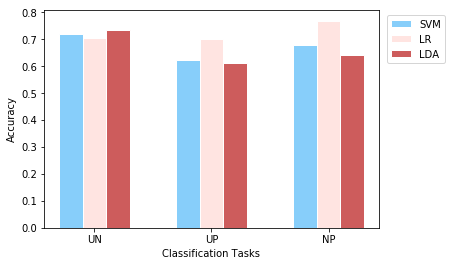

[[0.72, 0.7066666666666667, 0.7333333333333333], [0.6233766233766234, 0.7012987012987013, 0.6103896103896104], [0.6794871794871795, 0.7692307692307693, 0.6410256410256411]]


In [38]:
#Plot Accuracies
tasks = ['UN', 'UP', 'NP']
labels = ['SVM', 'LR', 'LDA']
plotEvalMetrics(tasks, labels, accuracies, 'Accuracy')
print(accuracies)

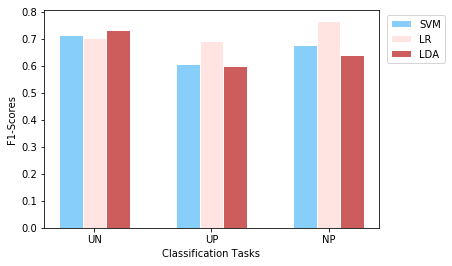

In [39]:
#Plot F1 Scores
tasks = ['UN', 'UP', 'NP']
labels = ['SVM', 'LR', 'LDA']
plotEvalMetrics(tasks, labels, f1_scores, 'F1-Scores')

### Overview

We train three different classifiers to classify EEG responses to three different conditions, at the single participant level. The test accuracy values obtained from the models are provided  in the first plot above. According to the results, LDA provided the best perfromance on the first task which is classification of unpleasant and neutral events. For classification of unpleasant and pleasant events, logistic regression is the best performing model by surpassing other models with a noticable difference. For the third task that classifies neutral and pleasant events, accuracy values vary from model to model and logistic regrassion is by far the best perfoming model. Although till now it is mentioned that certain models performed better on certain tasks, anyone could not reach above 77%.   

Although accuracy is one of the most common evaluation metrics for machine learning models, it is not enough to conclude a model is performing than another. It may be deceptive in some cases. For example when a model classifies a majority of the instances to one class, accuracy can still be high if the classes are highly imbalanced. Another case would be when false postive and false negative have different consequences. Especially in the medical domain, this case is an important aspect while evaluating models. Therefore, precision, recall and f1-score, which is a metric combining precision and recall, should be considered besides accuracy. 

The plot of F1-scores (second plot) demonstrates results similar to the accuracy plot.